# Using a Custom Elman RNN for MNIST Classification (row and sequential)

In this notebook, we implement a **custom Elman RNN** to classify the **MNIST dataset** in both **row-wise** and **sequential** formats.

### Overview of the Implementation:
We define two key components:
1. ````CustomRNNLayer```` – A single-layer recurrent neural network (Elman RNN).
2. ````RNNBackbone```` – A full RNN-based model that stacks one or more `CustomRNNLayer` instances and adds a ```final linear layer``` to classify MNIST digits.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
from tqdm import tqdm
import lightning as L

import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys 
sys.path.append('../Flax')


In [4]:
if torch.cuda.is_available():
    print("CUDA is available")
    print(torch.cuda.get_device_name())
    device = torch.device("cuda")
    print(device)
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())

else:
    print("CUDA is not available")
    device = torch.device("cpu")

# set random seed
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

CUDA is available
NVIDIA GeForce RTX 4090
cuda
0
1


In [5]:
from utils import create_mnist_classification_dataset

In [6]:
# Hyperparameters
BATCH_SIZE = 128
HIDDEN_SIZE = 256
LEARNING_RATE = 0.001
N_LAYERS = 1
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_VERSION = "row" # "sequential" or "row"

# Create dataset
train_loader, val_loader, test_loader, n_classes, seq_length, in_dim = create_mnist_classification_dataset(
    bsz=BATCH_SIZE, version=DATASET_VERSION
)

batch_images, batch_labels = next(iter(train_loader))
print(batch_images.shape)
print(batch_labels.shape)


[*] Generating MNIST Classification Dataset...
(128, 28, 28)
(128,)


In [7]:
# Create model

class LightningRNNBackbone(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, criterion, batch_size, n_layers=1):
        '''
        RNN backbone using 1 recurrent layer and 1 readout layer
        '''
        super().__init__()
        self.batch_size = batch_size
        self.criterion = criterion
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.rnn_layer = nn.LSTM(input_size, hidden_size, num_layers=n_layers, batch_first=True)
        for name, param in self.rnn_layer.named_parameters():
            if 'weight_hh_l' in name:
                nn.init.orthogonal_(param)
                print(name)
            elif 'weight_ih_l' in name:
                nn.init.normal_(param)
                # scale weight_ih_l0
                k = 1/np.sqrt(hidden_size)
                param.data = param.data * k
                # clamp weight_ih_l0
                param.data = torch.clamp(param.data, -2*k, 2*k)
                print(name)
            if 'bias' in name:
                nn.init.zeros_(param)
        self.W_out = nn.Linear(hidden_size, output_size, bias=True)
        self.logger_kwargs = {"batch_size": batch_size, "on_epoch": True, "on_step":True, "prog_bar": True}

    def forward(self, x):
        # x shape: [seq_len, input_size] or [batch_size, seq_len, input_size]
        
        # state_hist, out_hist = self.rnn_layer(x)
        h = torch.zeros(1*self.n_layers, self.batch_size, self.hidden_size).to(self.device)
        c = torch.zeros(1*self.n_layers, self.batch_size, self.hidden_size).to(self.device)
        state_hist, _ = self.rnn_layer(x, (h, c))
        out_hist = self.W_out(state_hist)
        return state_hist, out_hist
    
    def run_batch(self, batch):
        # x shape: [seq_len, input_size] or [batch_size, seq_len, input_size]
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        y = torch.tensor(y, dtype=torch.long).to(self.device)
        # state_hist, out_hist = self.rnn_layer(x)
        state_hist, out_hist = self(x)
        final_outputs = out_hist.mean(dim=1)
        loss = self.criterion(final_outputs, y)
        one_hot = torch.zeros_like(final_outputs)
        one_hot[torch.arange(len(y)), y] = 1
        accuracy = (final_outputs.argmax(dim=1) == y).float().mean()
        return loss, accuracy

    
    def training_step(self, batch, batch_idx):

        loss, acc = self.run_batch(batch)
        # Logging to TensorBoard (if installed) by default
        # self.log("train_loss", loss, prog_bar=True, on_epoch=True, batch_size=128)
        self.log("train_loss", loss, **self.logger_kwargs) 
        self.log("train_acc", acc, **self.logger_kwargs)

        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        loss, acc = self.run_batch(batch)
        self.log("val_loss", loss, **self.logger_kwargs) 
        self.log("val_acc", acc, **self.logger_kwargs)
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        loss, acc = self.run_batch(batch)
        self.log("test_loss", loss, **self.logger_kwargs) 
        self.log("test_acc", acc, **self.logger_kwargs)
        return loss

    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [8]:
model = LightningRNNBackbone(in_dim, HIDDEN_SIZE, n_classes, nn.CrossEntropyLoss(), BATCH_SIZE, n_layers=N_LAYERS)
model.to(device)
print(model.device)


weight_ih_l0
weight_hh_l0
cuda:0


In [9]:
# model.rnn_layer.Wh.weight.min(), model.rnn_layer.Wh.weight.max() 

In [10]:
# from lightning.pytorch.callbacks import RichProgressBar

# # train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
# callbacks = [RichProgressBar(leave=True)]
from lightning.pytorch.loggers import TensorBoardLogger
logger = TensorBoardLogger("logs/", name="rnn_experiment")

from lightning.pytorch.callbacks import TQDMProgressBar
callbacks = [TQDMProgressBar(leave=True)]
trainer = L.Trainer(max_epochs=5, callbacks=callbacks,
                    log_every_n_steps=50,
                    #limit_train_batches=200, 
                    enable_progress_bar=True, logger=logger)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | rnn_layer | LSTM             | 292 K  | train
2 | W_out     | Linear           | 2.6 K  | train
-------------------------------------------------------
295 K     Trainable params
0         Non-trainable params
295 K     Total params
1.182     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 390/390 [00:08<00:00, 46.97it/s, v_num=59, train_loss_step=0.0372, train_acc_step=0.992, val_loss_step=0.0304, val_acc_step=0.984, val_loss_epoch=0.0756, val_acc_epoch=0.976, train_loss_epoch=0.0629, train_acc_epoch=0.981]


`Trainer.fit` stopped: `max_epochs=5` reached.


In [41]:
# test the model
trainer.test(model, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 78/78 [00:01<00:00, 45.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.1447315663099289     │
│      test_loss_epoch      │    2.2875869274139404     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 2.2875869274139404, 'test_acc_epoch': 0.1447315663099289}]

In [12]:
batch_images, batch_labels = next(iter(test_loader))
batch_images = torch.tensor(batch_images, dtype=torch.float32).to(device)
batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)

print(batch_images.device)
print(batch_labels.device)
print(model.device)
model.to(device)
model.eval()
with torch.no_grad():
    state_hist, out_hist = model(batch_images)
    print(state_hist.shape)
    print(out_hist.shape)
    final_outputs = out_hist.mean(dim=1)
    preds = final_outputs.argmax(dim=1)
    accuracy = (preds == batch_labels).float().mean()
    print(f"Accuracy: {accuracy.item() * 100:.2f}%")
    print(f"Predictions: {preds}")
    print(f"Ground Truth: {batch_labels}")
    print(f"Loss: {F.cross_entropy(final_outputs, batch_labels)}")
    

cuda:0
cuda:0
cpu
torch.Size([128, 28, 256])
torch.Size([128, 28, 10])
Accuracy: 98.44%
Predictions: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 6, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 7,
        5, 4, 7, 6, 7, 9, 0, 5], device='cuda:0')
Ground Truth: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5], de

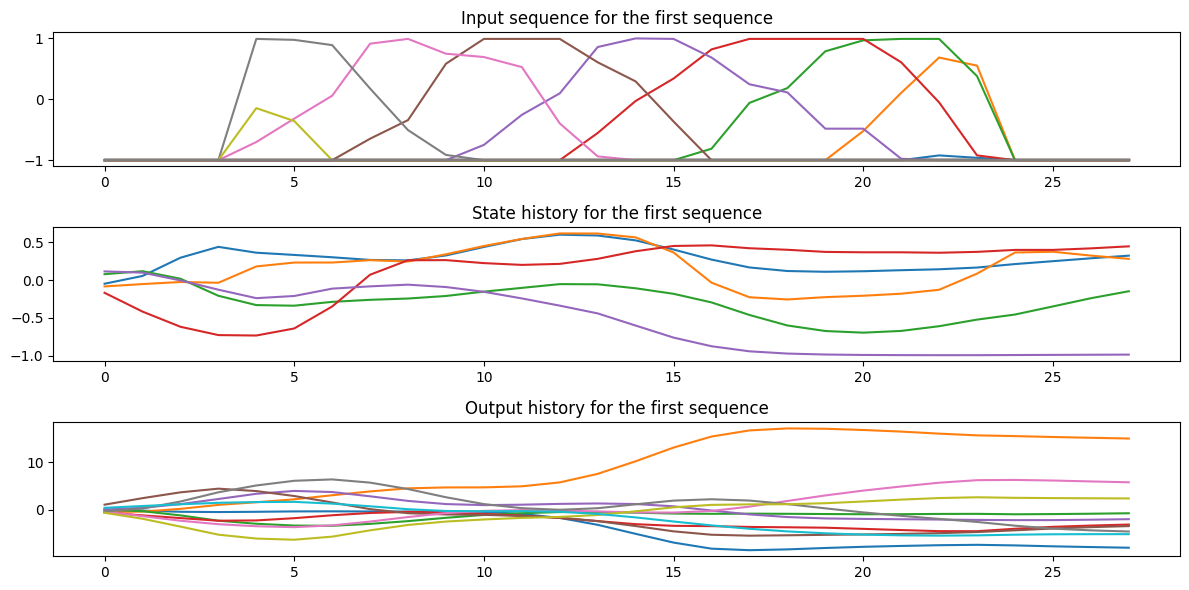

In [13]:
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']  # pixel in inches

fig, axs = plt.subplots(3, 1, figsize=(1200*px, 600*px))
id_sample = 2
axs[0].plot(batch_images[id_sample].cpu().numpy())
axs[0].set_title("Input sequence for the first sequence")
axs[1].plot(state_hist[id_sample, :, :5].cpu().numpy())
axs[1].set_title("State history for the first sequence")
axs[-1].plot(out_hist[id_sample, :, :].cpu().numpy())
axs[-1].set_title("Output history for the first sequence")
# axs[1].set_yticks(np.arange(0,1.1, 0.1))
# axs[1].grid()
plt.tight_layout()
plt.show()

In [22]:
!pip freeze | grep torch

/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


pytorch-lightning==2.5.0.post0
torch==2.2.1+cu118
torchmetrics==1.6.1
torchvision==0.17.1+cu118
